# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b6863e32-c74e-1bd2-229c-111259adb075)


In [ ]:
import plotly.graph_objs as go
from google.colab import drive
import pandas as pd
import seaborn as sns
import plotly.offline as py
import plotly.figure_factory as ff
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE

import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.8.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# 2. Prepare the data in NumPy 

Suppose that this example deals with the single-label multi-class classification problem where a single input is a 1D vector of shape (100,) and there are 10 predefined classes of output.

1. Load train and test data
2. Data preprocessing
3. Format the data (e.g, shape, dtype) to suit with the model's requirement (e.g., MLP)

In [ ]:
# # Load Data from Google Drive

# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/MyDrive/DADS 7202 Deep Learning/02_Deep Learning_HW1_MLP/Data Set/hotel_bookings.csv')
# data.shape


In [ ]:
# Load Data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
data= pd.read_csv('/content/drive/MyDrive/DAD7202/hotel_bookings.csv')

Mounted at /content/drive


In [ ]:
data['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [ ]:
data.drop(['company'],inplace=True,axis=1)
data['agent'].fillna(data['agent'].mode()[0],inplace=True)
data['country'].fillna(data['country'].mode()[0],inplace=True)
data['children'].fillna(data['children'].mean(),inplace=True)

In [ ]:
categorical_columns=[]
continuous_columns=[]
for col in data.columns:
    if data[col].dtype!='object':
        continuous_columns.append(col)
    else:
        categorical_columns.append(col)
    

In [ ]:
hotel_bookings_df=data

In [ ]:
hotel_bookings_df['arrival_date_month'] = hotel_bookings_df['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
hotel_bookings_df['hotel'] = hotel_bookings_df['hotel'].map({'Resort Hotel':0, 'City Hotel':1})
hotel_bookings_df["total_members"] = hotel_bookings_df["adults"] + hotel_bookings_df["children"] + hotel_bookings_df["babies"]
hotel_bookings_df["total_stay"] = hotel_bookings_df["stays_in_weekend_nights"]+ hotel_bookings_df["stays_in_week_nights"]
hotel_bookings_df.drop(columns = ['adults', 'babies', 'children', 'stays_in_weekend_nights', 'stays_in_week_nights'],inplace=True,axis=1)

In [ ]:
le = LabelEncoder()
hotel_bookings_df['meal'] = le.fit_transform(hotel_bookings_df['meal'])
hotel_bookings_df['country'] = le.fit_transform(hotel_bookings_df['country'])
hotel_bookings_df['distribution_channel'] = le.fit_transform(hotel_bookings_df['distribution_channel'])
hotel_bookings_df['reserved_room_type'] = le.fit_transform(hotel_bookings_df['reserved_room_type'])
hotel_bookings_df['assigned_room_type'] = le.fit_transform(hotel_bookings_df['assigned_room_type'])
hotel_bookings_df['deposit_type'] = le.fit_transform(hotel_bookings_df['deposit_type'])
hotel_bookings_df['customer_type'] = le.fit_transform(hotel_bookings_df['customer_type'])
hotel_bookings_df['reservation_status'] = le.fit_transform(hotel_bookings_df['reservation_status'])
hotel_bookings_df['market_segment'] = le.fit_transform(hotel_bookings_df['market_segment'])
hotel_bookings_df['reservation_status_date'] = le.fit_transform(hotel_bookings_df['reservation_status_date'])
hotel_bookings_df['is_canceled'] = le.fit_transform(hotel_bookings_df['is_canceled'])

In [ ]:
hotel_bookings_df=hotel_bookings_df[['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_members',
       'total_stay', 'is_canceled']]

In [ ]:
hotel_bookings_df.drop(['reservation_status'],inplace=True,axis=1)

In [ ]:
hotel_bookings_df.drop(['arrival_date_year','arrival_date_day_of_month','assigned_room_type'],inplace=True,axis=1)

In [ ]:
X = hotel_bookings_df.drop(["is_canceled"], axis=1)
y = hotel_bookings_df["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 64)

sm = SMOTE(random_state=64)
X_res, y_res = sm.fit_resample(X_train, y_train)

X_res_train,X_val , y_res_train, y_val = train_test_split(X_res, y_res, test_size = 0.30, random_state = 64)

In [ ]:
from collections import Counter

print('Resampled dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 75166, 1: 44224})
Resampled dataset shape Counter({0: 52524, 1: 52524})


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier(random_state=42)
model2.fit(X_res_train, y_res_train)
DT_pred = model2.predict(X_test)

In [ ]:
%%time
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from sklearn import metrics

print(classification_report(y_test.values.tolist(),DT_pred))


fpr, tpr, thresholds = metrics.roc_curve(y_test.values.tolist(), DT_pred)
print('AUC score',metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     15837
           1       0.92      0.93      0.93     15678

    accuracy                           0.93     31515
   macro avg       0.93      0.93      0.93     31515
weighted avg       0.93      0.93      0.93     31515

AUC score 0.9270304700239701
CPU times: user 81 ms, sys: 9 µs, total: 81.1 ms
Wall time: 79.9 ms


# Logistic Regression

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0,verbose=5)
grid_result = grid_search.fit(X_res_train, y_res_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
CPU times: user 13 s, sys: 5.24 s, total: 18.2 s
Wall time: 1min 29s


In [ ]:
grid_result.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
model = LogisticRegression(C=1,penalty='l2',solver='newton-cg')
model.fit(X_res_train, y_res_train)
LR_pred = model.predict(X_test)

In [ ]:
%%time
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from sklearn import metrics

print(classification_report(y_test.values.tolist(),LR_pred))


fpr, tpr, thresholds = metrics.roc_curve(y_test.values.tolist(), LR_pred)
print('AUC score',metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78     15837
           1       0.79      0.74      0.77     15678

    accuracy                           0.77     31515
   macro avg       0.78      0.77      0.77     31515
weighted avg       0.78      0.77      0.77     31515

AUC score 0.7745401445616039
CPU times: user 117 ms, sys: 94.3 ms, total: 211 ms
Wall time: 109 ms


# Random Forest Model

In [ ]:
params = {
    'max_depth': [10,  50, 100],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50,200, 1000]}

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
clf = GridSearchCV(estimator= rf_model , param_grid=params, scoring='accuracy', return_train_score=True, verbose=1,cv=3)
clf.fit(X_res_train, y_res_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
CPU times: user 1h 28min 50s, sys: 1min 51s, total: 1h 30min 41s
Wall time: 1h 30min 25s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 50, 100],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 200, 1000]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
clf.best_params_

{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=50, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)
rf_model.fit(X_res_train, y_res_train)
re_pred = rf_model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from sklearn import metrics

print(classification_report(y_test.values.tolist(),re_pred))


fpr, tpr, thresholds = metrics.roc_curve(y_test.values.tolist(), re_pred)
print('AUC score',metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     15837
           1       0.95      0.93      0.94     15678

    accuracy                           0.94     31515
   macro avg       0.94      0.94      0.94     31515
weighted avg       0.94      0.94      0.94     31515

AUC score 0.9446054319984537


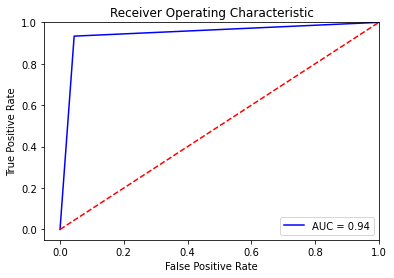

In [ ]:
import sklearn.metrics as metrics


roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1])
plt.ylim([-0.05, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# # method II: ggplot
# from ggplot import *
# df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
# ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

# XGBoost model

In [ ]:
param_grid = {'gamma': [0,10,51,200],
              'learning_rate': [0.01, 0.25, 0.7],
              'max_depth': [5,10,14],
              'n_estimators': [50,200, 1000]
              }

In [ ]:
%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier()

clf_xgb_model = GridSearchCV(estimator= xgb_model , param_grid=param_grid, scoring='accuracy', return_train_score=True, verbose=1,cv=3)
clf_xgb_model.fit(X_res_train, y_res_train,X_val,y_val)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
CPU times: user 3h 52min 56s, sys: 20.8 s, total: 3h 53min 17s
Wall time: 3h 52min 15s


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'gamma': [0, 10, 51, 200],
                         'learning_rate': [0.01, 0.25, 0.7],
                         'max_depth': [5, 10, 14],
                         'n_estimators': [50, 200, 1000]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
clf_xgb_model.best_params_

{'gamma': 0, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 1000}

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(gamma= 0, learning_rate= 0.25, max_depth= 10,n_estimators= 1000)

evalset = [(X_res, y_res), (X_val,y_val)]
xgb_model.fit(X_res_train, y_res_train,eval_metric='logloss',eval_set=evalset)
xgb_pred = xgb_model.predict(X_test)

[0]	validation_0-logloss:0.564878	validation_1-logloss:0.566063
[1]	validation_0-logloss:0.485621	validation_1-logloss:0.487186
[2]	validation_0-logloss:0.429732	validation_1-logloss:0.432073
[3]	validation_0-logloss:0.390006	validation_1-logloss:0.3934
[4]	validation_0-logloss:0.360295	validation_1-logloss:0.364552
[5]	validation_0-logloss:0.336301	validation_1-logloss:0.341374
[6]	validation_0-logloss:0.31851	validation_1-logloss:0.324123
[7]	validation_0-logloss:0.30316	validation_1-logloss:0.309452
[8]	validation_0-logloss:0.291779	validation_1-logloss:0.298331
[9]	validation_0-logloss:0.277342	validation_1-logloss:0.284359
[10]	validation_0-logloss:0.268974	validation_1-logloss:0.276585
[11]	validation_0-logloss:0.261315	validation_1-logloss:0.269098
[12]	validation_0-logloss:0.256891	validation_1-logloss:0.264792
[13]	validation_0-logloss:0.246707	validation_1-logloss:0.255287
[14]	validation_0-logloss:0.242848	validation_1-logloss:0.251575
[15]	validation_0-logloss:0.236117	vali

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from sklearn import metrics

print(classification_report(y_test.values.tolist(),xgb_pred))


fpr, tpr, thresholds = metrics.roc_curve(y_test.values.tolist(), xgb_pred)
print('AUC score',metrics.auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22642
           1       0.98      0.95      0.97     13175

    accuracy                           0.98     35817
   macro avg       0.98      0.97      0.97     35817
weighted avg       0.98      0.98      0.98     35817

AUC score 0.9715730887184351


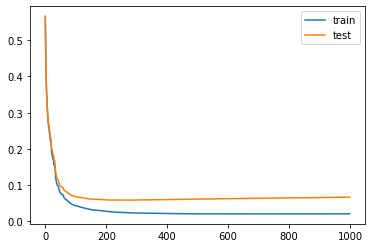

In [ ]:
from matplotlib import pyplot
results = xgb_model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

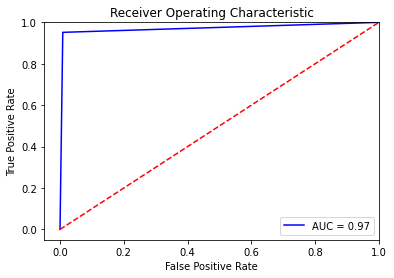

In [ ]:
import sklearn.metrics as metrics


roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1])
plt.ylim([-0.05, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# # method II: ggplot
# from ggplot import *
# df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
# ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

# Change Seed

random seed at : 1
AUC score (Train) 1.0
AUC score (Validation) 0.9809719151146603
AUC score (Test) 0.9715730887184351
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22642
           1       0.98      0.95      0.97     13175

    accuracy                           0.98     35817
   macro avg       0.98      0.97      0.97     35817
weighted avg       0.98      0.98      0.98     35817



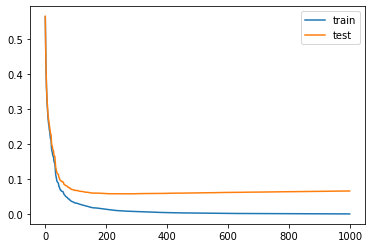

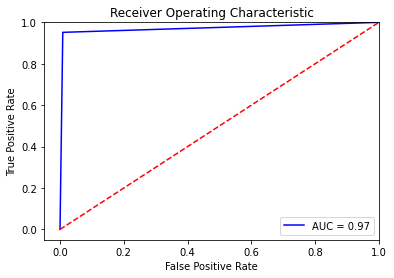

random seed at : 39
AUC score (Train) 1.0
AUC score (Validation) 0.9809719151146603
AUC score (Test) 0.9715730887184351
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22642
           1       0.98      0.95      0.97     13175

    accuracy                           0.98     35817
   macro avg       0.98      0.97      0.97     35817
weighted avg       0.98      0.98      0.98     35817



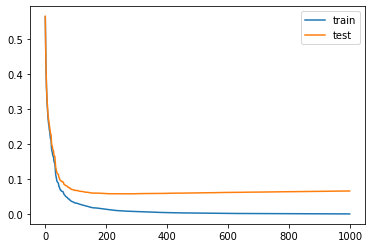

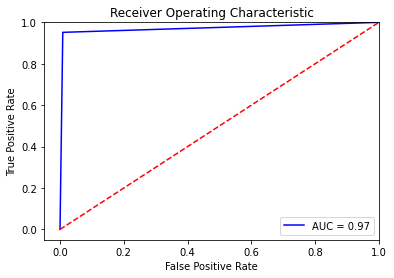

random seed at : 42
AUC score (Train) 1.0
AUC score (Validation) 0.9809719151146603
AUC score (Test) 0.9715730887184351
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22642
           1       0.98      0.95      0.97     13175

    accuracy                           0.98     35817
   macro avg       0.98      0.97      0.97     35817
weighted avg       0.98      0.98      0.98     35817



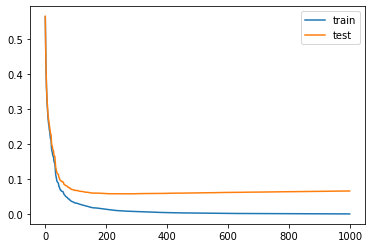

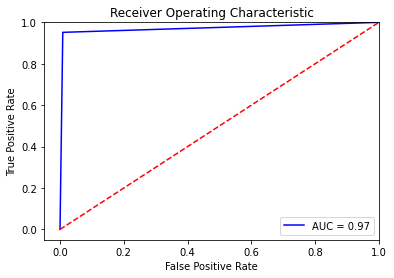

random seed at : 1234
AUC score (Train) 1.0
AUC score (Validation) 0.9809719151146603
AUC score (Test) 0.9715730887184351
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22642
           1       0.98      0.95      0.97     13175

    accuracy                           0.98     35817
   macro avg       0.98      0.97      0.97     35817
weighted avg       0.98      0.98      0.98     35817



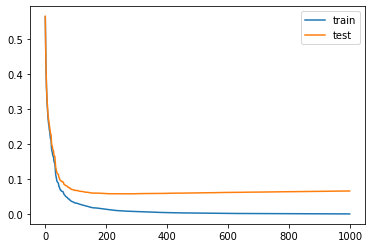

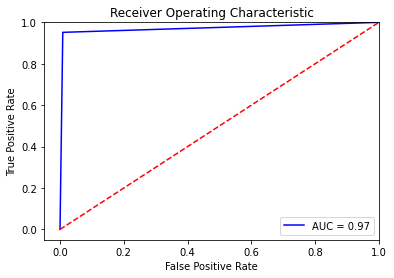

random seed at : 5678
AUC score (Train) 1.0
AUC score (Validation) 0.9809719151146603
AUC score (Test) 0.9715730887184351
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     22642
           1       0.98      0.95      0.97     13175

    accuracy                           0.98     35817
   macro avg       0.98      0.97      0.97     35817
weighted avg       0.98      0.98      0.98     35817



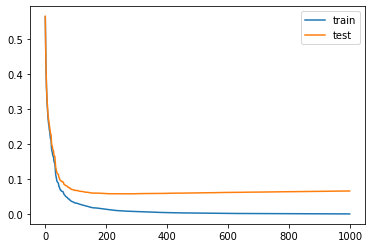

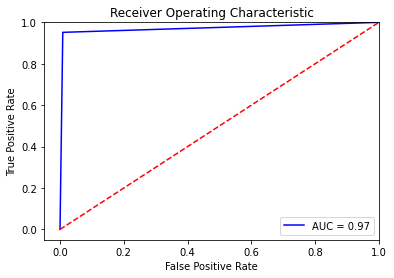

CPU times: user 15min 18s, sys: 1.37 s, total: 15min 20s
Wall time: 15min 18s


In [ ]:
%%time
import time
import sklearn.metrics as metrics
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import pyplot
import sklearn.metrics as metrics

seed_list =[1,39,42,1234,5678]
result = pd.DataFrame(columns=['set_seed','train_time','inference_time','auc_score'])
for seed in seed_list:
  print('random seed at :',seed)

  model = XGBClassifier(gamma= 0, learning_rate= 0.25, max_depth= 10,n_estimators= 1000,random_state=seed)
  evalset = [(X_res_train, y_res_train), (X_val,y_val)]

  train_start_time = time.time()
  model.fit(X_res_train, y_res_train,eval_metric='logloss',eval_set=evalset,verbose=0)
  train_end_time = time.time()
  
  inference_start_time = time.time()

  y_pred = model.predict( X_res_train )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
  inference_end_time = time.time()

  fpr, tpr, thresholds = metrics.roc_curve(y_res_train.values.tolist(), y_pred)
  print('AUC score (Train)',metrics.auc(fpr, tpr))

  value_result = {'data':'train','set_seed':seed,'train_time':train_end_time - train_start_time,'inference_time':inference_end_time-inference_start_time,'auc_score':metrics.auc(fpr, tpr),'f1_class0':metrics.f1_score(y_res_train, y_pred, average=None)[0],'f1_class1':metrics.f1_score(y_res_train, y_pred, average=None)[1]}
  result = result.append(value_result,ignore_index=True)

#-----------Validation-------------
  inference_start_time = time.time()

  y_pred = model.predict( X_val )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
  inference_end_time = time.time()

  fpr, tpr, thresholds = metrics.roc_curve(y_val.values.tolist(), y_pred)
  print('AUC score (Validation)',metrics.auc(fpr, tpr))

  value_result = {'data':'validation','set_seed':seed,'train_time':train_end_time - train_start_time,'inference_time':inference_end_time-inference_start_time,'auc_score':metrics.auc(fpr, tpr),'f1_class0':metrics.f1_score(y_val, y_pred, average=None)[0],'f1_class1':metrics.f1_score(y_val, y_pred, average=None)[1]}
  result = result.append(value_result,ignore_index=True)

#-----------Test-------------
  inference_start_time = time.time()

  y_pred = model.predict( X_test )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
  inference_end_time = time.time()

  fpr, tpr, thresholds = metrics.roc_curve(y_test.values.tolist(), y_pred)
  print('AUC score (Test)',metrics.auc(fpr, tpr))
  print(classification_report(y_test.values.tolist(),y_pred))

  value_result = {'data':'test','set_seed':seed,'train_time':train_end_time - train_start_time,'inference_time':inference_end_time-inference_start_time,'auc_score':metrics.auc(fpr, tpr),'f1_class0':metrics.f1_score(y_test, y_pred, average=None)[0],'f1_class1':metrics.f1_score(y_test, y_pred, average=None)[1]}
  result = result.append(value_result,ignore_index=True)

  
  results = model.evals_result()
  # plot learning curves
  pyplot.plot(results['validation_0']['logloss'], label='train')
  pyplot.plot(results['validation_1']['logloss'], label='test')
  # show the legend
  pyplot.legend()
  # show the plot
  pyplot.show()



  


  roc_auc = metrics.auc(fpr, tpr)

  # method I: plt
  
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([-0.05, 1])
  plt.ylim([-0.05, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  # # method II: ggplot
  # from ggplot import *
  # df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
  # ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

  value_result = {'set_seed':seed,'train_time':train_end_time - train_start_time,'inference_time':inference_end_time-inference_start_time,'auc_score':metrics.auc(fpr, tpr)}
  result = result.append(value_result,ignore_index=True)

In [ ]:
result 

,set_seed,train_time,inference_time,auc_score,data,f1_class0,f1_class1
0,1,166.449483,9.495325,1.000000,train,1.000000,1.000000
1,1,166.449483,4.065981,0.980972,validation,0.981314,0.980727
2,1,166.449483,4.622145,0.971573,test,0.981825,0.967929
4,39,164.914263,9.534301,1.000000,train,1.000000,1.000000
5,39,164.914263,4.094244,0.980972,validation,0.981314,0.980727
6,39,164.914263,4.707955,0.971573,test,0.981825,0.967929
8,42,164.438689,10.089189,1.000000,train,1.000000,1.000000
9,42,164.438689,4.068240,0.980972,validation,0.981314,0.980727
10,42,164.438689,4.660918,0.971573,test,0.981825,0.967929
12,1234,163.484496,9.494719,1.000000,train,1.000000,1.000000


In [ ]:
result[['data','train_time','inference_time','auc_score','f1_class0','f1_class1']].groupby('data').agg(['mean','std']).reset_index()

data train_time           inference_time           auc_score       \
                    mean       std           mean       std      mean  std   
0        test  164.81838  1.071597       4.655543  0.041879  0.971573  0.0   
1       train  164.81838  1.071597       9.621046  0.262287  1.000000  0.0   
2  validation  164.81838  1.071597       4.064657  0.019877  0.980972  0.0   

  f1_class0      f1_class1       
       mean  std      mean  std  
0  0.981825  0.0  0.967929  0.0  
1  1.000000  0.0  1.000000  0.0  
2  0.981314  0.0  0.980727  0.0